- Going to create models/predictions for GE


In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score


import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests



In [71]:
GE = "/Users/davidhoffman/desktop/stocks_download/GE_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(GE, index_col="Date", parse_dates=True)

In [72]:
#Only keep closing price of the day
df.drop(['Open','High','Low'], axis = 1, inplace = True)
df.drop(['Name'], axis = 1, inplace = True)
df.drop(['Volume'], axis = 1, inplace = True)

In [73]:
df.head()

,Close
Date,
2006-01-03,35.37
2006-01-04,35.32
2006-01-05,35.23
2006-01-06,35.47
2006-01-09,35.38


In [74]:
#Perform Dicky Fuller test to test for stationarity
# Function taken from class lecture


def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

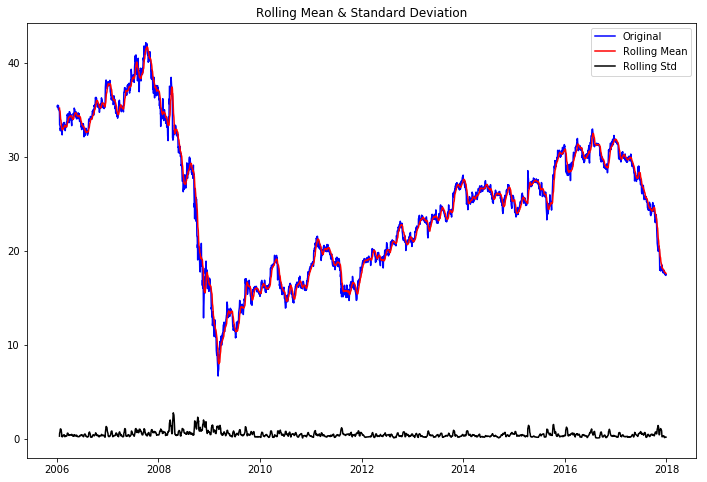

Results of Dickey-Fuller Test:
Test Statistic   -1.460985
p-value           0.552716
dtype: float64


In [75]:
#testing stationarity

test_stationarity(df.Close)

In [76]:
#High pvalue --> no stationarity
#Must get to a point of stationarity for the time series
#Will get the difference in my values
df['close_diff_1']=df.Close.diff()

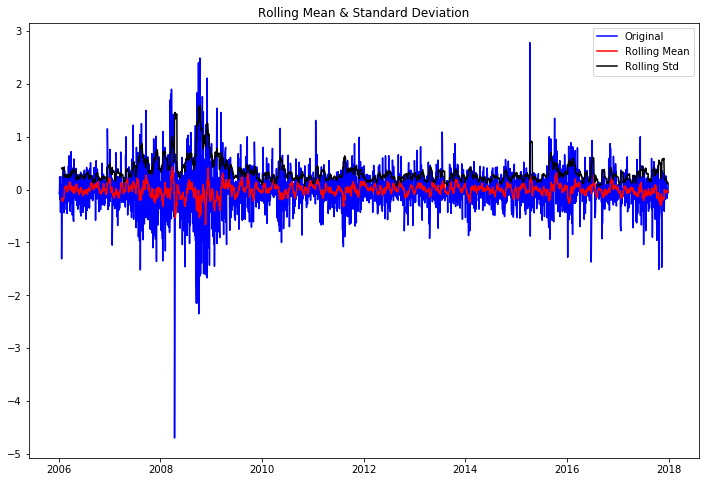

Results of Dickey-Fuller Test:
Test Statistic   -1.152525e+01
p-value           3.950623e-21
dtype: float64


In [77]:
test_stationarity(df.close_diff_1.dropna())

 - Everything below this cell was taken from
https://machinelearningmastery.com/make-sample-forecasts-arima-python/

- I was having difficuly understanding the fundamentals of how the ARIMA model worked, specifically the predicting/forecasting.

In [98]:
#going to split data into train and test
# train = entire df minus last 7 days
# test = the last 7 days from df that aren't included in training

In [99]:
train = df.Close[:-7]

In [100]:
test = df.Close[len(train-1):]

In [101]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [102]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


In [103]:
# load dataset
series = train
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2647
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2251.482
Method:                       css-mle   S.D. of innovations              0.566
Date:                Mon, 02 Apr 2018   AIC                           4510.963
Time:                        14:28:10   BIC                           4534.488
Sample:                             1   HQIC                          4519.479
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.010     -0.643      0.520      -0.027       0.013
ar.L1.D.y      0.1639      0.210      0.781      0.435      -0.248       0.575
ma.L1.D.y     -0.2244      0.207     -1.084      0.2

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [104]:
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]

# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [105]:
# load dataset
series = train
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Forecast: 17.686870


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [106]:

series = train
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7)[0]
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Day 1: 17.686870
Day 2: 17.805162
Day 3: 18.072980
Day 4: 18.345201
Day 5: 18.400152
Day 6: 18.440827
Day 7: 18.311470


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [113]:
# load dataset
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# load dataset
series = train
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Day 1: 17.686870
Day 2: 17.805162
Day 3: 18.072980
Day 4: 18.345201
Day 5: 18.400152
Day 6: 18.440827
Day 7: 18.311470


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [110]:
test

Date
2017-12-20    17.45
2017-12-21    17.47
2017-12-22    17.50
2017-12-26    17.43
2017-12-27    17.38
2017-12-28    17.36
2017-12-29    17.45
Name: Close, dtype: float64